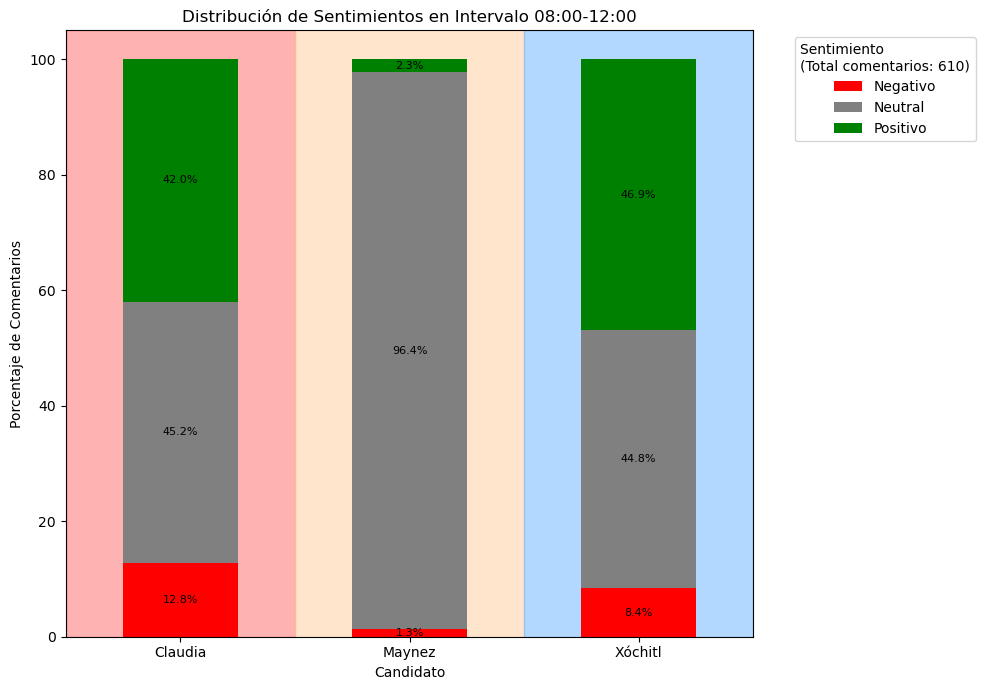

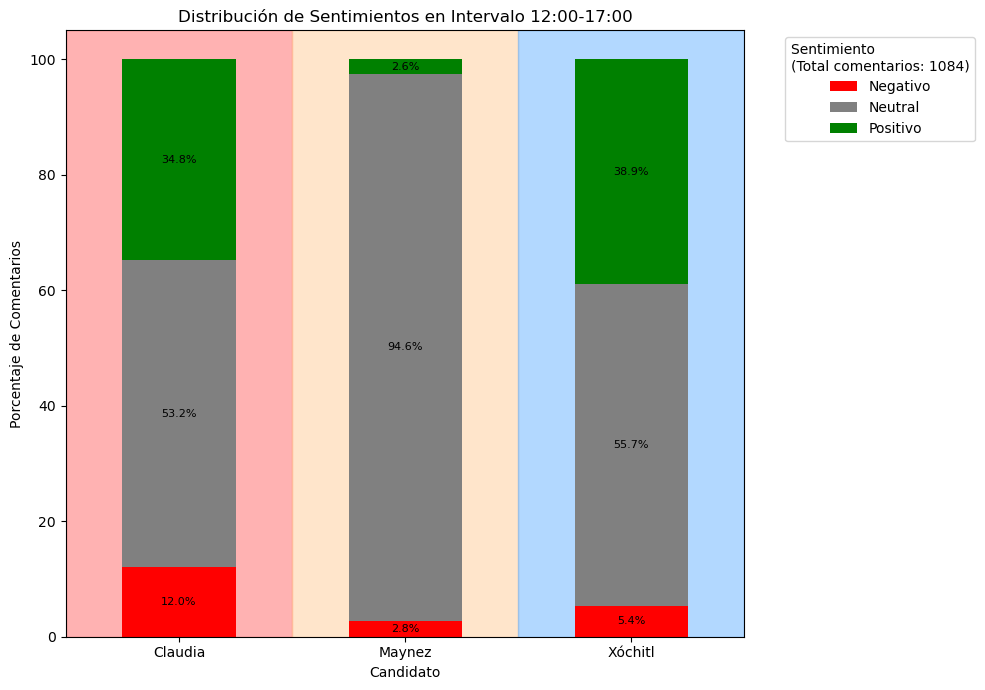

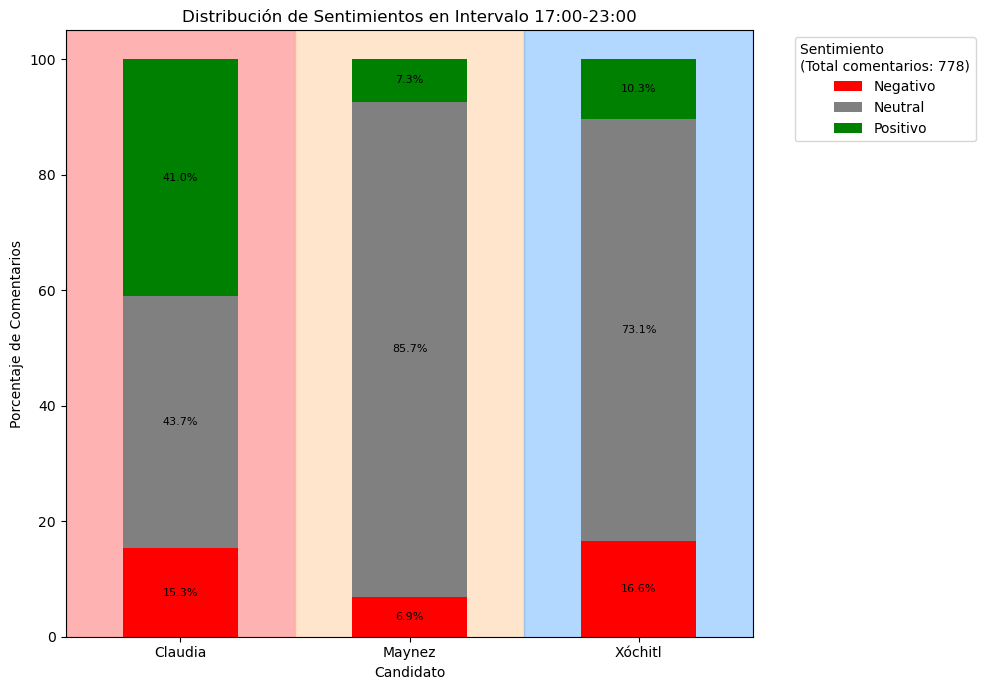

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos asegurando que las comillas sean manejadas correctamente
data = pd.read_csv("diaEleccion.csv", quotechar='"')

# Filtrar columnas relevantes y excluir 'Ninguno'
data = data[['hora de publicación', 'Claudia', 'Maynez', 'Xóchitl']]

# Crear una función para asignar intervalos de tiempo
def asignar_intervalo(hora):
    if "08:00" <= hora <= "12:00":
        return "08:00-12:00"
    elif "12:01" <= hora <= "17:00":
        return "12:00-17:00"
    elif "17:01" <= hora <= "23:00":
        return "17:00-23:00"
    else:
        print(f"Puerco, {hora}")
        return "Fuera de rango"

# Asignar intervalos a las horas de publicación
data['intervalo'] = data['hora de publicación'].apply(asignar_intervalo)

# Transformar los datos para análisis (melt para formato largo)
summary = data.melt(id_vars=['intervalo'],  # Solo 'intervalo' permanece fijo
                    value_vars=['Claudia', 'Maynez', 'Xóchitl'],  # Candidatos a transformar
                    var_name='candidato', 
                    value_name='sentimiento')

# Agrupar por intervalo, candidato y sentimiento
summary_counts = summary.groupby(['intervalo', 'candidato', 'sentimiento']).size().reset_index(name='conteo')

# Crear gráficos de barras apiladas por intervalo
for intervalo in summary_counts['intervalo'].unique():
    # Filtrar datos para el intervalo actual
    intervalo_data = summary_counts[summary_counts['intervalo'] == intervalo]

    # Calcular el total de comentarios
    total_comentarios = intervalo_data['conteo'].sum()

    # Pivotar los datos para formato adecuado
    pivot_table = intervalo_data.pivot(index='candidato', 
                                       columns='sentimiento', 
                                       values='conteo').fillna(0)

    # Calcular porcentajes
    pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

    # Asegurarse de que las columnas sean strings y las etiquetas correctas
    pivot_table_percentage.columns = pivot_table_percentage.columns.astype(str)
    pivot_table_percentage = pivot_table_percentage.rename(columns={'-1': 'Negativo', '0': 'Neutral', '1': 'Positivo'})

    # Crear gráfico de barras apiladas con fondos personalizados
    fig, ax = plt.subplots(figsize=(10, 7))

    # Colores de fondo por candidato
    background_colors = {
        'Claudia': '#ff6666',  # Rojo pastel intenso
        'Maynez': '#ffcc99',   # Naranja pastel intenso
        'Xóchitl': '#66b2ff'  # Azul pastel intenso
    }

    # Dibujar fondos personalizados
    for i, candidato in enumerate(pivot_table_percentage.index):
        color = background_colors.get(candidato, '#ffffff')  # Blanco por defecto si no está en el diccionario
        ax.axvspan(i - 0.5, i + 0.5, color=color, alpha=0.5)

    # Dibujar barras apiladas
    pivot_table_percentage.plot(kind='bar', stacked=True, ax=ax, 
                                color={'Negativo': 'red', 'Neutral': 'gray', 'Positivo': 'green'})

    # Agregar etiquetas de porcentaje
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=8, color='black')

    # Títulos y etiquetas
    plt.title(f"Distribución de Sentimientos en Intervalo {intervalo}")
    plt.xlabel("Candidato")
    plt.ylabel("Porcentaje de Comentarios")
    plt.xticks(rotation=0)
    
    # Agregar leyenda con el total de comentarios
    legend_title = f"Sentimiento \n(Total comentarios: {int(total_comentarios/3)})"
    plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Guardar el gráfico
    plt.savefig(f"sA_intervalo_{intervalo}.pdf", format="pdf")
    plt.show()
